In [716]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn 
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import json
import os
import random
import io

In [717]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

In [718]:
device

device(type='cuda')

In [873]:
X = []
all_events = []
masks = []
X_id = []

def get_signal(filename):
    with open(filename, 'r') as f:
        return json.load(f)[0]


def get_events(filename):
    with open(filename, 'rb') as f:
        events = json.load(f)
    events = list(filter(lambda x: x["type"] == 1, events))
    events = list(filter(lambda x: x["data"]["type"] >= 5, events))
    return events

def x_corrected(X, masks, X_id):
    x_8951 = []
    mask_8951 = []
    x_116615 = []
    mask_116615 = []
    x_116909 = []
    mask_116909 = []
    for i in range(len(X_id)):
        
        if X_id[i] == "17470_signal.json":
            X[i] = X[i][:6000000]
            masks[i] = masks[i][:6000000]
            
        elif X_id[i] == "116615_signal.json":
            x_116615.append(X[i][2423014:5671675])
            mask_116615.append(masks[i][2423014:5671675])
            
            X[i] = X[i][:1009860]
            masks[i] = masks[i][:1009860]
            
        elif X_id[i] == "116909_signal.json":
            
            x_116909.append(X[i][7163202:9160980])
            mask_116909.append(masks[i][7163202:9160980])
            
            X[i] = X[i][:4427637]
            masks[i] = masks[i][:4427637]
            
        elif X_id[i] == "20464_signal.json":
            X[i] = X[i][1797672:4221158]
            masks[i] = masks[i][1797672:4221158]
            
        elif X_id[i] == "118552_signal.json":
            X[i] = X[i][3878216:4750764]
            masks[i] = masks[i][3878216:4750764]
            
        elif X_id[i] == "118651_signal.json":
            X[i] = X[i][28118412:29268580]
            masks[i] = masks[i][28118412:29268580]

        elif X_id[i] == "118548_signal.json":
            X[i] = X[i][758756:1412460]
            masks[i] = masks[i][758756:1412460]
        
        elif X_id[i] == "118547_signal.json":
            X[i] = X[i][10402460:12956676]
            masks[i] = masks[i][10402460:12956676]    
            
        elif X_id[i] == "8951_signal.json":

            x_8951.append(X[i][11101472:17100332])
            x_8951.append(X[i][3875159:4217497])
            mask_8951.append(masks[i][11101472:17100332])
            mask_8951.append(masks[i][3875159:4217497])
            
            X[i] = X[i][176579:1650787]
            masks[i] = masks[i][176579:1650787]
            
    X = X + x_8951 + x_116909 + x_116615
    masks = masks + mask_8951 + mask_116909 + mask_116615
    X_id = X_id + 2 * ['8951_signal.json'] + ['116909_signal.json'] + ['116615_signal.json']
        
    return X, masks, X_id


directory = 'ecg/'
for filename in sorted(os.listdir(directory)):
    path = directory + "/" + filename
    if "signal" in filename:
        X.append(get_signal(path))
        X_id.append(filename)
    if "events" in filename:
        all_events.append(get_events(path))
        
for signal, events in zip(X, all_events):
    mask = np.zeros(len(signal), dtype=np.int8)
    for event in events:
        m = event["data"]
        mask[m["begin"]:m["end"]] = m["type"] - 4
    masks.append(mask)
    
X, masks, X_id = x_corrected(X,masks, X_id)

for i in range(len(X)):
    X[i] = np.array(X[i]) * 0.001
    
X = np.array(X, dtype=object)
masks = np.array(masks, dtype=object)

In [874]:
sample_rate = 500

In [875]:
# Вспомогательные функции, превращающие маску в сегментацию

v_to_del = {1:'noise', 2:'artefacts'}

def remove_small(signal):
    max_dist = 12
    last_zero = 0
    for i in range(len(signal)):
        if signal[i] == 0:
            if i - last_zero < max_dist:
                signal[last_zero:i] = 0
            last_zero = i

def merge_small(signal):
    max_dist = 100
    lasts = np.full(signal.max() + 1, -(max_dist+1))
    for i in range(len(signal)):
        m = signal[i]
        if i - lasts[m] < max_dist and m > 0:
            signal[lasts[m]:i] = m
        lasts[m] = i

def mask_to_delineation(mask):
    merge_small(mask)
    remove_small(mask)
    delineation = {'noise':[], 'artefacts':[]}
    i = 0
    mask_length = len(mask)
    while i < mask_length:
        v = mask[i]
        if v > 0:
            delineation[v_to_del[v]].append([i, 0])
            while i < mask_length and mask[i] == v:
                delineation[v_to_del[v]][-1][1] = i
                i += 1
            t = delineation[v_to_del[v]][-1]
        i += 1
    return delineation

In [876]:
wave_type_to_color = {
    "artefacts": "yellow",
    "noise": "red"
}

def plot_signal_with_mask(signal, mask):
    plt.figure(figsize=(18, 5))
    plt.title("Сигнал с маской")
    plt.xlabel("Время (сек)")
    plt.ylabel("Амплитуда (мВ)")
    x_axis_values = np.linspace(0, len(signal) / sample_rate, len(signal))
    plt.plot(x_axis_values, signal, linewidth=2, color="black")
    
    delineation = mask_to_delineation(mask)
    for wave_type in ["noise", "artefacts"]:
        color = wave_type_to_color[wave_type]
        for begin, end in delineation[wave_type]:
            begin /= sample_rate
            end /= sample_rate
            plt.axvspan(begin, end, facecolor=color, alpha=0.5)

In [877]:
type_ecg = {'стандарт': # 0
                np.array(['117310_signal.json',
                         '117311_signal.json', 
                         '117312_signal.json', 
                         '117316_signal.json',
                         '117460_signal.json',
                         '117461_signal.json',
                         '117472_signal.json',
                         '117473_signal.json',
                         '17464_signal.json',
                         '17470_signal.json',
                         '17554_signal.json',
                         '17555_signal.json',
                         '8951_signal.json']),
            
           'высокий пульс': # 1
                np.array(['117542_signal.json']),
            'смешанные': # 2
                np.array(['116615_signal.json',
                         '118547_signal.json',
                         '118548_signal.json']),
            'V6': # 3
                np.array(['116909_signal.json']),
            'III': # 4     
                np.array(['116621_signal.json',
                         '118651_signal.json']),
            
            'экстрасистолы': # 5
                np.array(['20464_signal.json',
                         '118552_signal.json'])
            
           }

In [878]:
def get_type_ecg(signal_id):
    keys = type_ecg.keys()
    for i, key in enumerate(keys):
        if(np.where(type_ecg[key] == signal_id)[0].size != 0):
            return i
    return -1

In [879]:
# разделение данных на обучающую и тестовую выборки
def balance(i,X,masks): #разделение у одного сигнала
    X_balance = []
    masks_balance = []
    X_balance_id = []
    X_balance_start = []
    index = 0
    r = random.randint(8,12)*500*60
    type_balance = []
    while len(X) - index >= r:
        
        X_balance.append(X[index:index + r])
        masks_balance.append(masks[index:index + r])
        X_balance_id.append(X_id[i])
        
        if i == 12: #118547
            X_balance_start.append(index + 10402460)
        elif i == 13: #118548
            X_balance_start.append(index + 758756)
        elif i == 14: #118552
            X_balance_start.append(index + 3878216)
        elif i == 15: #118651
            X_balance_start.append(index + 28118412)
        elif i == 20: #20464
            X_balance_start.append(index + 1797672)
        elif i == 21: #8951
            X_balance_start.append(index + 176579)
        elif i == 22: #8951
            X_balance_start.append(index + 11101472)
        elif i == 23: #8951
            X_balance_start.append(index + 3875159)
        elif i == 24: #116909
            X_balance_start.append(index + 7163202)
        elif i == 25: #116615
            X_balance_start.append(index + 2513218)    
        else: X_balance_start.append(index)
            
        index += r
        r = random.randint(8,12)*500*60
    
    type_balance = [get_type_ecg(X_id[i])] * len(X_balance)
        
    return X_balance, masks_balance, X_balance_id, X_balance_start, type_balance

X_balance = []
masks_balance = []
X_balance_id = []
X_balance_start = []
type_balance = []
for i in range(len(X)):
    x,y,z,d,t = balance(i, X[i], masks[i])
    X_balance += x
    masks_balance += y
    X_balance_id += z
    X_balance_start += d
    type_balance += t
    
print("Фрагментов по 8-12 минут: ", len(X_balance))

for i in range(len(X_balance)):
    X_balance[i] = np.array(X_balance[i])
    masks_balance[i] = np.array(masks_balance[i])

Фрагментов по 8-12 минут:  258


In [890]:
signals_train, signals_test, masks_train, masks_test = \
    train_test_split(X_balance, masks_balance, random_state=42, shuffle=True, stratify = type_balance)

In [891]:
_, _, id_train, id_test = \
   train_test_split(X_balance, X_balance_id, random_state=42, shuffle=True, stratify = type_balance)

In [892]:
_, _, start_train, start_test = \
   train_test_split(X_balance, X_balance_start, random_state=42, shuffle=True, stratify = type_balance)

In [893]:
#signals_train = X_balance
#signals_test = []
#masks_train = masks_balance
#masks_test = []
#id_train = X_balance_id
#id_test = []
#start_train = X_balance_start
#start_test = []

In [894]:
print(len(signals_train))
print(len(signals_test))
print(len(id_train))
print(len(id_test))

193
65
193
65


In [895]:
np.save("train-test-data/signals_train", np.array(signals_train, dtype = object))
np.save("train-test-data/signals_test", np.array(signals_test, dtype = object))
np.save("train-test-data/masks_train", np.array(masks_train, dtype = object))
np.save("train-test-data/masks_test", np.array(masks_test, dtype = object))
np.save("train-test-data/id_train", np.array(id_train, dtype = object))
np.save("train-test-data/id_test", np.array(id_test, dtype = object))
np.save("train-test-data/start_train", np.array(start_train, dtype = object))
np.save("train-test-data/start_test", np.array(start_test, dtype = object))

In [896]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, signals, masks):
        self._signals = signals
        self._masks = masks
        self._sub_len = 500 * 30
        self._sim_len = 500 * 2
        self._probs = [len(s) for s in self._signals]
        self._probs = np.array(self._probs)
        self._probs = self._probs / self._probs.sum()
        self._arange = np.arange(len(self._signals))
        self._sample_probs = []
        for mask in self._masks:
            (unique, counts) = np.unique(mask, return_counts=True)
            self._sample_probs.append(self._get_probs(mask, unique, counts))
        self._sim = []
        
        r = np.zeros(self._sim_len)
        r[:self._sim_len//2] = np.arange(self._sim_len//2)
        r[self._sim_len//2:] = np.arange(self._sim_len - self._sim_len//2)[::-1]
        r = r / np.sum(r)
        matrix = np.array([[1, 0, 0.5], [0, 1, 0.25], [0.5, 0.25, 1]])
        for mask in self._masks:
            self._sim.append(self._get_sim(mask, r, matrix))
    
    
    def _get_probs(self, mask, unique, counts):
        w = {}
        for u, c in zip(unique, counts):
            w[u] = 1 / c
        result = []
        s = 0
        for i in range(self._sub_len):
            s += w[mask[i]]
        result.append(s)
        for i in range(self._sub_len, len(mask)):
            s += w[mask[i]] - w[mask[i - self._sub_len]]
            result.append(s)
        result = np.array(result)
        return result / np.sum(result)
    
    def _get_sim(self, mask, r, matrix):
        result = np.ones(len(mask))
        result = np.zeros(len(mask))
        for i in range(len(mask) - self._sim_len + 1):
            index = i + self._sim_len//2
            x = mask[index]
            values = matrix[x, mask[i:i+len(r)]]
            result[index] = np.sum(r * values)
        result = 2 * result / (1.2 - result)
        return result

    def __len__(self):
        return 15 * len(self._signals)

    def __getitem__(self, i):
        index = np.random.choice(self._arange, p=self._probs)
        signal = self._signals[index]
        #shift = np.random.choice(np.arange(len(self._sample_probs[index])), p=self._sample_probs[index])
        shift = np.random.randint(0, len(signal) - self._sub_len + 1)
        signal = signal[shift:shift+self._sub_len].reshape(1, -1)
        mask = self._masks[index][shift:shift+self._sub_len]
        sim = self._sim[index][shift:shift+self._sub_len]
        return torch.FloatTensor(signal), torch.LongTensor(mask), torch.LongTensor(sim)

In [897]:
def get_loader(signals, masks, batch_size=4):
    dataset = SegmentationDataset(signals, masks)
    return DataLoader(dataset, batch_size=batch_size)

In [898]:
batch_size = 128

train_loader = get_loader(signals_train, masks_train, batch_size)
val_loader = get_loader(signals_test, masks_test, batch_size)

In [899]:
import torch.nn.functional as F

weights = torch.Tensor([1., 15., 15.])
weights = weights.to(device)


def get_loss_with_confusion(model, X_batch, y_batch, w):
    logits = model(X_batch)
    logits = logits[:, :, 2000:-2000]
    y_batch = y_batch[:, 2000:-2000]
    w = w[:, 2000:-2000]
    loss = (w * F.cross_entropy(logits, y_batch, weight=weights)).mean()
    
    y_batch = y_batch.to(cpu)
    logits = logits.to(cpu)
    
    y_batch = y_batch.data.numpy().reshape(-1)
    logits = logits.data.numpy()
    y_pred = np.argmax(logits, axis=1).reshape(-1)
    return loss, confusion_matrix(y_batch, y_pred, labels=(0, 1, 2))
    

def get_loss(model, X_batch, y_batch, w):
    logits = model(X_batch)
    logits = logits[:, :, 2000:-2000]
    y_batch = y_batch[:, 2000:-2000]
    w = w[:, 2000:-2000]
    return (w * F.cross_entropy(logits, y_batch, weight=weights)).mean()

In [900]:
class Drawer():
    def __init__(self):
        self._train = []
        self._val = []
    
    def add(self, train_loss, val_iou):
        self._train.append(train_loss)
        self._val.append(val_iou)
        
    def plot(self):
        epochs = range(1, 1 + len(self._train))
        plt.figure(figsize=(10, 8))
        plt.title('train/val loss')
        plt.xlabel('Эпоха')
        plt.ylabel('Loss')
        plt.plot(epochs, self._train)
        plt.plot(epochs, self._val)
        plt.legend(["train", "val"])
        plt.show()

In [901]:
import time

def fit(model, train_loader, val_loader, optimizer, loss_function, num_epochs=None):
    train_losses = []
    val_losses = []
    drawer = Drawer()
    min_loss = 1e6
    min_loss_index = 0
    epoch = 0
    
    while num_epochs is None or epoch < num_epochs:
        start_time = time.time()
        model.train()
        for X_batch, y_batch, w in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            w = w.to(device)
            loss = loss_function(model, X_batch, y_batch, w)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss = loss.to(cpu)
            train_losses.append(loss.data.numpy())

        model.eval()
        confusion_all = np.zeros((3, 3))
        for X_batch, y_batch, w in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            w = w.to(device)
            loss, confusion = get_loss_with_confusion(model, X_batch, y_batch, w)
            loss = loss.to(cpu)
            confusion_all += confusion
            val_losses.append(loss.data.numpy())
    
            
        train_loss = np.mean(train_losses[-len(train_loader):])
        val_loss = np.mean(val_losses[-len(val_loader):])
        print(len(train_loader), len(val_loader))
        drawer.add(train_loss, val_loss)
        
        clear_output(True)
        drawer.plot()
        print("Epoch {} took {:.3f}s".format(epoch + 1, time.time() - start_time))
        print("training loss: \t{:.6f}".format(train_loss))
        print("validation loss: \t{:.6f}".format(val_loss))
        print(confusion_all / confusion_all.sum())
        
        if val_loss < min_loss - 1e-5:
            min_loss = val_loss
            min_loss_index = epoch
        elif epoch - min_loss_index >= 10:
            #break
            pass
        
        epoch += 1

In [902]:
class UNetConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetConv, self).__init__()
        self._model = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=9, padding=4),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=9, padding=4),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, X):
        return self._model(X)
    
    
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDown, self).__init__()
        self._model = nn.Sequential(
            nn.MaxPool1d(3),
            UNetConv(in_channels, out_channels)
        )
    
    def forward(self, X):
        return self._model(X)
    

class UNetUp(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels):
        super(UNetUp, self).__init__()
        self._up = nn.ConvTranspose1d(in_channels, in_channels, kernel_size=9, stride=3, padding=3)
        self._model = UNetConv(in_channels + in_channels_skip, out_channels)
    
    def forward(self, X_skip, X):
        X = self._up(X)  
        diff = X_skip.size()[2] - X.size()[2]
        X = F.pad(X, (diff // 2, diff - diff // 2))  
        return self._model(torch.cat([X_skip, X], dim=1))

In [903]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        n = 4
        self._input = UNetConv(in_channels, n)
        self._down1 = UNetDown(n, 2*n)
        self._down2 = UNetDown(2*n, 4*n)
        self._down3 = UNetDown(4*n, 8*n)
        self._down4 = UNetDown(8*n, 16*n)
        self._up1 = UNetUp(16*n, 8*n, 8*n)
        self._up2 = UNetUp(8*n, 4*n, 4*n)
        self._up3 = UNetUp(4*n, 2*n, 2*n)
        self._up4 = UNetUp(2*n, n, n)
        self._output = nn.Conv1d(n, num_classes, kernel_size=1)
        
    def forward(self, X):
        x1 = self._input(X)
        x2 = self._down1(x1)
        x3 = self._down2(x2)
        x4 = self._down3(x3)
        x = self._down4(x4)
        x = self._up1(x4, x)
        x = self._up2(x3, x)
        x = self._up3(x2, x)
        x = self._up4(x1, x)
        return self._output(x)

In [904]:
model = UNet(1, 3)

In [906]:
optimizer = torch.optim.Adam(model.parameters())

In [907]:
model = model.to(device)

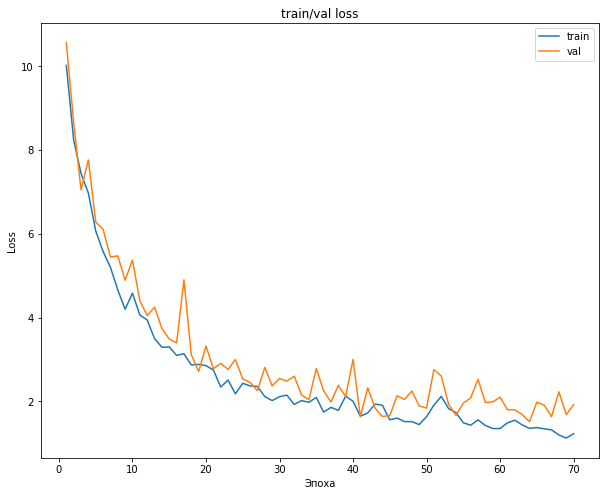

Epoch 70 took 10.062s
training loss: 	1.225947
validation loss: 	1.917650
[[9.21190956e-01 3.72261072e-03 2.57774359e-02]
 [1.09370629e-04 1.04612587e-02 2.50069930e-04]
 [3.54722611e-03 6.88111888e-04 3.42529604e-02]]


In [908]:
fit(model, train_loader, val_loader, optimizer, get_loss,70)

In [909]:
model.eval()

UNet(
  (_input): UNetConv(
    (_model): Sequential(
      (0): Conv1d(1, 4, kernel_size=(9,), stride=(1,), padding=(4,))
      (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(4, 4, kernel_size=(9,), stride=(1,), padding=(4,))
      (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (_down1): UNetDown(
    (_model): Sequential(
      (0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (1): UNetConv(
        (_model): Sequential(
          (0): Conv1d(4, 8, kernel_size=(9,), stride=(1,), padding=(4,))
          (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(8, 8, kernel_size=(9,), stride=(1,), padding=(4,))
          (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
 

In [910]:
model = model.to("cpu")

In [911]:
torch.save(model.state_dict(), "20.04.21/unet")

In [912]:
torch.jit.save(torch.jit.script(model), "20.04.21/unetjit")